# HW2 - Speech Enhancement in Reverberant Environments

**Q1(a):** Generate Room Impulse Responses (RIRs) and visualize them in the time domain for different reverberation times.

## Setup and Imports

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
print(os.getcwd())


# Add rir-generator to path
# sys.path.insert(0, 'rir-generator/src/rir_generator')
import rir_generator as rir

np.random.seed(42)

/home/moran/courses/speech_signal_processign/hw2/speech_signal_processing_hw_2


## Simulation Parameters

In [75]:
# Room configuration
room_dim = [4.0, 5.0, 3.0]  # meters
c = 343.0  # speed of sound (m/s)
fs = 16000  # sample rate (Hz)

# Reverberation times to test
t60_ms_list = [150, 300]  # milliseconds

# Microphone array: 5-element ULA along x-axis, centered at [2, 1, 1.7]
n_mics = 5
d_mic = 0.05  # 5 cm spacing
center = np.array([2.0, 1.0, 1.7])

# Build mic positions: indices -2, -1, 0, 1, 2
mic_positions = []
for k in range(-2, 3):
    pos = center.copy()
    pos[0] += k * d_mic
    mic_positions.append(pos)
mic_positions = np.array(mic_positions)

# Source at 30 degrees, 1.5m from center
theta_src = np.deg2rad(30)
r_src = 1.5
source_pos = np.array([
    center[0] + r_src * np.cos(theta_src),
    center[1] + r_src * np.sin(theta_src),
    center[2]
])

print(f"Room: {room_dim} m")
print(f"Mic array center: {center}")
print(f"Mic positions (x): {mic_positions[:, 0]}")
print(f"Source position: {source_pos}")

Room: [4.0, 5.0, 3.0] m
Mic array center: [2.  1.  1.7]
Mic positions (x): [1.9  1.95 2.   2.05 2.1 ]
Source position: [3.29903811 1.75       1.7       ]


## Generate RIRs for Different T60 Values

In [76]:
# Generate RIRs for each reverberation time
rir_dict = {}

for t60_ms in t60_ms_list:
    t60 = t60_ms / 1000.0  # convert to seconds
    n_samples = int(np.ceil(t60 * fs))  # as specified: nsample = T60 * fs
    
    # Generate RIR using rir_generator
    h = rir.generate(
        c=c,
        fs=fs,
        r=mic_positions,
        s=source_pos,
        L=room_dim,
        reverberation_time=t60,
        nsample=n_samples
    )
    rir_dict[t60_ms] = h
    print(f"T60={t60_ms}ms: RIR shape = {h.shape} (samples x mics)")

T60=150ms: RIR shape = (2400, 5) (samples x mics)
T60=300ms: RIR shape = (4800, 5) (samples x mics)


## Plot RIRs in Time Domain (First Microphone)

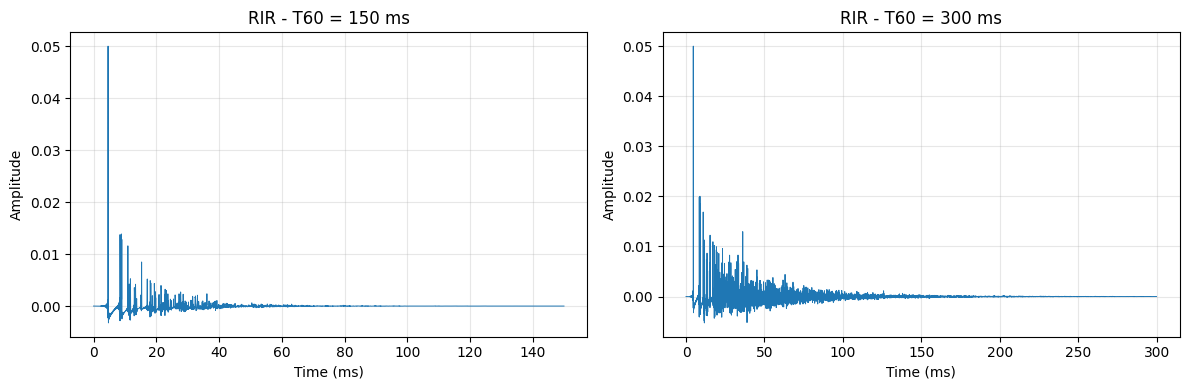

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, t60_ms in enumerate(t60_ms_list):
    h = rir_dict[t60_ms]
    h_mic1 = h[:, 0]  # first microphone
    t = np.arange(len(h_mic1)) / fs * 1000  # time in ms
    
    axes[idx].plot(t, h_mic1, linewidth=0.7)
    axes[idx].set_xlabel('Time (ms)')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(f'RIR - T60 = {t60_ms} ms')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Q1(b): Generate Measured Signals via Convolution

In [78]:
import scipy.signal as sig
import librosa

# Load a speech sample from LibriSpeech
speech_file = './speech_data/6241-61943-0001.flac'
speech, _ = librosa.load(speech_file, sr=fs)

print(f"Speech signal: {len(speech)} samples ({len(speech)/fs:.2f} sec)")

Speech signal: 51520 samples (3.22 sec)


In [79]:
# Convolve speech with RIRs to create multichannel "clean" reverberant signals
clean_signals = {}

for t60_ms, h in rir_dict.items():
    n_samples_rir, n_mics = h.shape
    out_len = len(speech) + n_samples_rir - 1
    
    # Convolve speech with each mic's RIR
    y = np.zeros((n_mics, out_len))
    for m in range(n_mics):
        y[m] = sig.fftconvolve(speech, h[:, m])
    
    clean_signals[t60_ms] = y
    print(f"T60={t60_ms}ms: output shape = {y.shape} (mics x samples)")

T60=150ms: output shape = (5, 53919) (mics x samples)
T60=300ms: output shape = (5, 56319) (mics x samples)


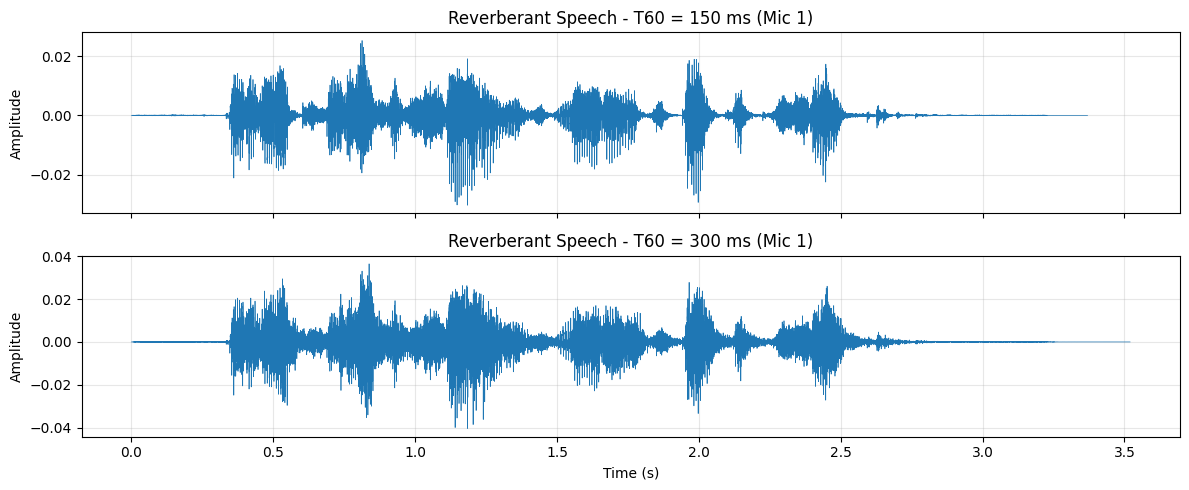

In [80]:
# Plot measured signal at first microphone for both T60 values
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

for idx, t60_ms in enumerate(t60_ms_list):
    y = clean_signals[t60_ms]
    t = np.arange(y.shape[1]) / fs
    
    axes[idx].plot(t, y[0], linewidth=0.5)
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(f'Reverberant Speech - T60 = {t60_ms} ms (Mic 1)')
    axes[idx].grid(True, alpha=0.3)

axes[1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Q1(c): Add Noise to Measured Signals

Two noise types:
1. **White Gaussian Noise** - spatially and spectrally white
2. **Interfering Speaker** - at 150°, 2m from array center

In [81]:
# SNR levels to test
snr_levels = [0, 10]  # dB

# Reference microphone for SNR calculation (center mic)
ref_mic = 2

def scale_noise_to_snr(clean, noise, target_snr_db, ref_mic=2):
    """Scale noise to achieve target SNR at reference microphone."""
    p_clean = np.mean(clean[ref_mic] ** 2)
    p_noise = np.mean(noise[ref_mic] ** 2)
    # SNR = 10*log10(p_clean / p_noise) => p_noise_scaled = p_clean / 10^(SNR/10)
    scale = np.sqrt(p_clean / (p_noise * 10 ** (target_snr_db / 10)))
    return noise * scale

### Noise Type 1: White Gaussian Noise (spatially uncorrelated)

In [82]:
# Generate noisy signals with white Gaussian noise
noisy_wgn = {}  # noisy_wgn[t60_ms][snr_db] = (noisy_signal, noise)

for t60_ms in t60_ms_list:
    noisy_wgn[t60_ms] = {}
    clean = clean_signals[t60_ms]
    
    for snr_db in snr_levels:
        # Independent white noise at each mic
        noise = np.random.randn(*clean.shape)
        noise_scaled = scale_noise_to_snr(clean, noise, snr_db, ref_mic)
        noisy = clean + noise_scaled
        noisy_wgn[t60_ms][snr_db] = (noisy, noise_scaled)
        
        print(f"T60={t60_ms}ms, SNR={snr_db}dB: added WGN")

T60=150ms, SNR=0dB: added WGN
T60=150ms, SNR=10dB: added WGN
T60=300ms, SNR=0dB: added WGN
T60=300ms, SNR=10dB: added WGN


### Noise Type 2: Interfering Speaker

In [83]:
# Interferer position: 150 degrees, 2m from array center
theta_int = np.deg2rad(150)
r_int = 2.0
interferer_pos = np.array([
    center[0] + r_int * np.cos(theta_int),
    center[1] + r_int * np.sin(theta_int),
    center[2]
])

# Load a different speech file as interferer
interferer_file = './speech_data/2086-149214-0001.flac'
interferer_speech, _ = librosa.load(interferer_file, sr=fs)

print(f"Interferer position: {interferer_pos}")
print(f"Interferer signal: {len(interferer_speech)} samples")

Interferer position: [0.26794919 2.         1.7       ]
Interferer signal: 111520 samples


In [84]:
# Generate RIRs for interferer location
rir_interferer = {}
for t60_ms in t60_ms_list:
    t60 = t60_ms / 1000.0
    n_samples = int(np.ceil(t60 * fs))
    h_int = rir.generate(
        c=c, fs=fs, r=mic_positions, s=interferer_pos,
        L=room_dim, reverberation_time=t60, nsample=n_samples
    )
    rir_interferer[t60_ms] = h_int

print("Generated RIRs for interferer")

Generated RIRs for interferer


In [85]:
def pad_to_length(x, L):
    """Zero-pad signal to length L."""
    if x.shape[1] >= L:
        return x[:, :L]
    out = np.zeros((x.shape[0], L))
    out[:, :x.shape[1]] = x
    return out

# Generate noisy signals with interfering speaker
noisy_interferer = {}  # noisy_interferer[t60_ms][snr_db] = (noisy_signal, interference)

for t60_ms in t60_ms_list:
    noisy_interferer[t60_ms] = {}
    clean = clean_signals[t60_ms]
    h_int = rir_interferer[t60_ms]
    
    # Crop/tile interferer to match target speech length
    int_len = len(speech)
    if len(interferer_speech) < int_len:
        int_sig = np.tile(interferer_speech, int(np.ceil(int_len / len(interferer_speech))))[:int_len]
    else:
        # Random crop
        start = np.random.randint(0, len(interferer_speech) - int_len + 1)
        int_sig = interferer_speech[start:start + int_len]
    
    # Convolve interferer with its RIRs
    int_conv = np.zeros((n_mics, int_len + h_int.shape[0] - 1))
    for m in range(n_mics):
        int_conv[m] = sig.fftconvolve(int_sig, h_int[:, m])
    
    # Align lengths
    max_len = max(clean.shape[1], int_conv.shape[1])
    clean_pad = pad_to_length(clean, max_len)
    int_pad = pad_to_length(int_conv, max_len)
    
    for snr_db in snr_levels:
        int_scaled = scale_noise_to_snr(clean_pad, int_pad, snr_db, ref_mic)
        noisy = clean_pad + int_scaled
        noisy_interferer[t60_ms][snr_db] = (noisy, int_scaled)
        
        print(f"T60={t60_ms}ms, SNR={snr_db}dB: added interfering speaker")

T60=150ms, SNR=0dB: added interfering speaker
T60=150ms, SNR=10dB: added interfering speaker
T60=300ms, SNR=0dB: added interfering speaker
T60=300ms, SNR=10dB: added interfering speaker


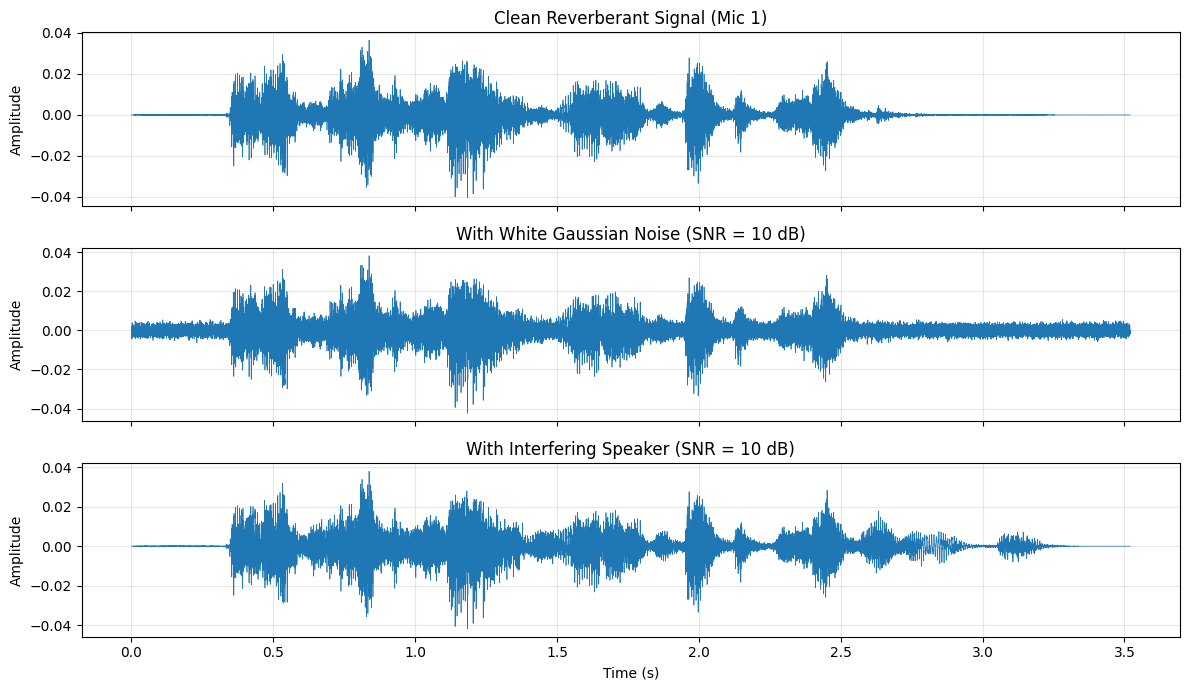

In [86]:
# Plot example: T60=300ms, SNR=10dB - compare both noise types
t60_show = 300
snr_show = 10

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

clean = clean_signals[t60_show]
noisy_w, _ = noisy_wgn[t60_show][snr_show]
noisy_i, _ = noisy_interferer[t60_show][snr_show]

# Align lengths for plotting
max_len = max(clean.shape[1], noisy_w.shape[1], noisy_i.shape[1])
t = np.arange(max_len) / fs

axes[0].plot(t[:clean.shape[1]], clean[0], linewidth=0.5)
axes[0].set_title('Clean Reverberant Signal (Mic 1)')
axes[0].set_ylabel('Amplitude')

axes[1].plot(t[:noisy_w.shape[1]], noisy_w[0], linewidth=0.5)
axes[1].set_title(f'With White Gaussian Noise (SNR = {snr_show} dB)')
axes[1].set_ylabel('Amplitude')

axes[2].plot(t[:noisy_i.shape[1]], noisy_i[0], linewidth=0.5)
axes[2].set_title(f'With Interfering Speaker (SNR = {snr_show} dB)')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time (s)')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Q1(d): Time and Frequency Domain Plots

Plot original, clean reverberant, and noisy signals (T60=300ms, SNR=10dB) in both time and frequency domains.

In [87]:
def plot_time_and_spectrum(signal, fs, title):
    """Plot signal in time domain and its magnitude spectrum."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    # Time domain
    t = np.arange(len(signal)) / fs
    axes[0].plot(t, signal, linewidth=0.5)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'{title} - Time Domain')
    axes[0].grid(True, alpha=0.3)
    
    # Frequency domain (magnitude spectrum using Welch's method)
    from scipy.signal import welch
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    axes[1].semilogy(freqs, psd, linewidth=0.8)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('PSD')
    axes[1].set_title(f'{title} - Power Spectrum')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

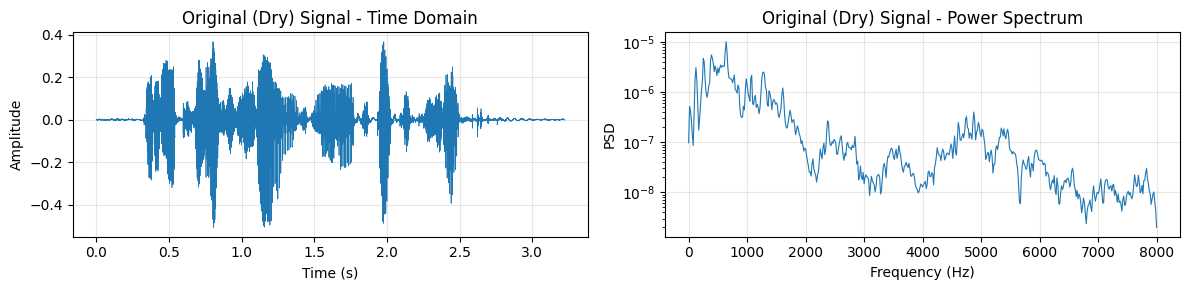

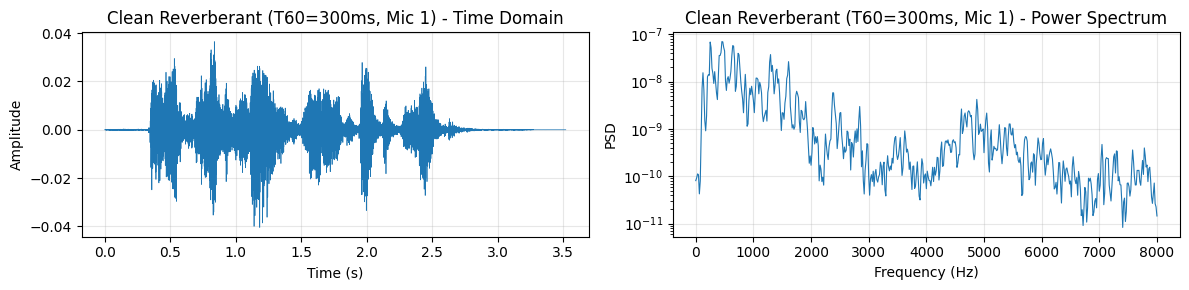

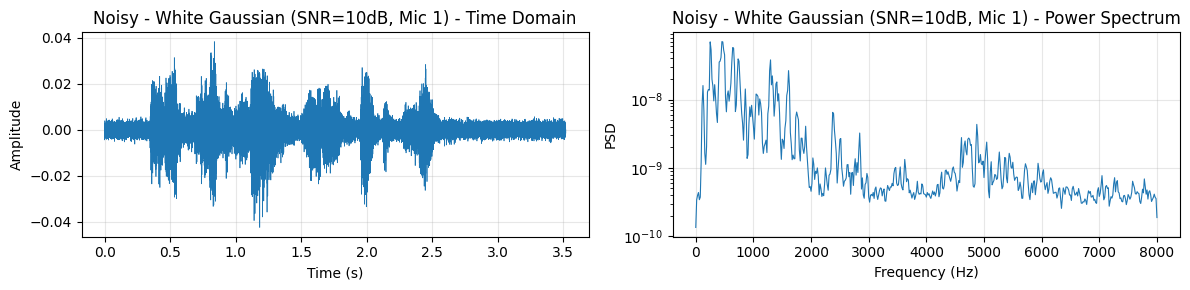

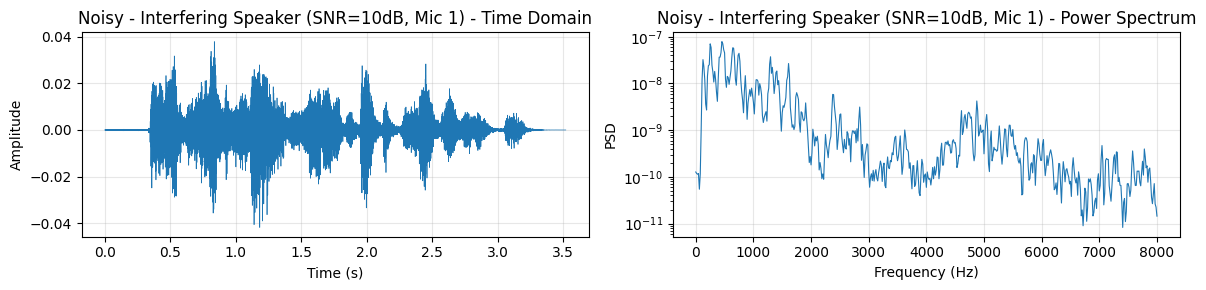

In [88]:
# Settings for plots
t60_plot = 300
snr_plot = 10

# Get signals
original = speech
clean_rev = clean_signals[t60_plot][0]  # first mic
noisy_wgn_sig, _ = noisy_wgn[t60_plot][snr_plot]
noisy_int_sig, _ = noisy_interferer[t60_plot][snr_plot]

# Plot each signal
plot_time_and_spectrum(original, fs, 'Original (Dry) Signal')
plot_time_and_spectrum(clean_rev, fs, 'Clean Reverberant (T60=300ms, Mic 1)')
plot_time_and_spectrum(noisy_wgn_sig[0], fs, 'Noisy - White Gaussian (SNR=10dB, Mic 1)')
plot_time_and_spectrum(noisy_int_sig[0], fs, 'Noisy - Interfering Speaker (SNR=10dB, Mic 1)')

In [ ]:
import scipy.signal as sig
import librosa

# Load a speech sample from LibriSpeech
speech_file = './speech_data/6241-61943-0001.flac'
speech, _ = librosa.load(speech_file, sr=fs)

print(f"Speech signal: {len(speech)} samples ({len(speech)/fs:.2f} sec)")

Speech signal: 51520 samples (3.22 sec)


## Q1(e): Save Noisy Signals as WAV Files

In [89]:
import soundfile as sf
import os

# Create output directory
out_dir = './outputs'
os.makedirs(out_dir, exist_ok=True)

# Save noisy signals (first microphone, T60=300ms, SNR=10dB)
# Normalize to prevent clipping
def normalize(x):
    return x / (np.max(np.abs(x)) + 1e-8)

sf.write(f'{out_dir}/noisy_wgn_300ms_10dB.wav', normalize(noisy_wgn_sig[0]), fs)
sf.write(f'{out_dir}/noisy_interferer_300ms_10dB.wav', normalize(noisy_int_sig[0]), fs)

print(f"Saved WAV files to {out_dir}/")

Saved WAV files to ./outputs/


---
# Question 2: Beamforming

Reference microphone: center of array (index 2)

## Q2(a): Delay-and-Sum Beamformer

The DS beamformer aligns signals from all microphones by compensating for propagation delays, then averages them.

In [90]:
# STFT parameters
n_fft = 512
hop_length = 128

def compute_steering_vector(mic_pos, src_pos, freqs, c, ref_mic=2):
    """
    Compute frequency-domain steering vector for known geometry.
    
    The steering vector represents the relative phase shifts across microphones
    for a signal arriving from the source location.
    
    Returns: (n_mics, n_freqs) complex array
    """
    mic_pos = np.array(mic_pos)
    # Distance from source to each mic
    distances = np.linalg.norm(mic_pos - src_pos, axis=1)
    # Time delays
    delays = distances / c
    # Relative delays w.r.t. reference mic
    delays_rel = delays - delays[ref_mic]
    # Steering vector: exp(-j * 2 * pi * f * tau)
    steering = np.exp(-2j * np.pi * np.outer(delays_rel, freqs))
    return steering  # (n_mics, n_freqs)

In [91]:
def delay_and_sum(x_multichannel, fs, mic_pos, src_pos, n_fft=512, hop=128, ref_mic=2):
    """
    Delay-and-Sum beamformer in STFT domain.
    
    Args:
        x_multichannel: (n_mics, n_samples) input signals
        fs: sampling rate
        mic_pos: microphone positions
        src_pos: source position (known)
        n_fft, hop: STFT parameters
        ref_mic: reference microphone index
    
    Returns:
        y: beamformed output signal
    """
    n_mics = x_multichannel.shape[0]
    
    # Compute STFT for each channel
    X = np.array([librosa.stft(x_multichannel[m], n_fft=n_fft, hop_length=hop) 
                  for m in range(n_mics)])  # (n_mics, n_freqs, n_frames)
    
    n_freqs, n_frames = X.shape[1], X.shape[2]
    freqs = np.fft.rfftfreq(n_fft, d=1/fs)
    
    # Compute steering vector
    d = compute_steering_vector(mic_pos, src_pos, freqs, c, ref_mic)  # (n_mics, n_freqs)
    
    # Apply DS beamformer: w = d / M (simple averaging after phase alignment)
    Y = np.zeros((n_freqs, n_frames), dtype=np.complex128)
    
    for f in range(n_freqs):
        w = d[:, f:f+1] / n_mics  # (n_mics, 1)
        Xf = X[:, f, :]           # (n_mics, n_frames)
        Y[f, :] = (w.conj().T @ Xf).ravel()
    
    # Inverse STFT
    y = librosa.istft(Y, hop_length=hop)
    return y

In [92]:
# Test DS beamformer on one example
t60_test = 300
snr_test = 10

noisy_wgn_test, _ = noisy_wgn[t60_test][snr_test]
noisy_int_test, _ = noisy_interferer[t60_test][snr_test]

# Apply DS beamformer
ds_out_wgn = delay_and_sum(noisy_wgn_test, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)
ds_out_int = delay_and_sum(noisy_int_test, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)

print(f"DS beamformer output length: {len(ds_out_wgn)} samples")

DS beamformer output length: 56192 samples


## Q2(b): MVDR Beamformer

MVDR (Minimum Variance Distortionless Response) minimizes output noise power while preserving the target signal.

Steps:
1. Estimate noise covariance matrix $\mathbf{R}_n$ from noise-only signals
2. Estimate RTF (Relative Transfer Function) using GEVD
3. Compute MVDR weights

In [93]:
from scipy.linalg import eigh, pinv

def estimate_covariance(X_freq):
    """
    Estimate covariance matrix from STFT frames at a single frequency bin.
    
    Args:
        X_freq: (n_mics, n_frames) complex STFT values
    
    Returns:
        R: (n_mics, n_mics) covariance matrix
    """
    n_mics, n_frames = X_freq.shape
    R = np.zeros((n_mics, n_mics), dtype=np.complex128)
    for t in range(n_frames):
        x = X_freq[:, t:t+1]
        R += x @ x.conj().T
    return R / n_frames

In [94]:
def mvdr_beamformer(x_noisy, noise_only, fs, n_fft=512, hop=128, ref_mic=2):
    """
    MVDR beamformer using GEVD-based RTF estimation.
    
    Args:
        x_noisy: (n_mics, n_samples) noisy multichannel signal
        noise_only: (n_mics, n_samples) noise-only signal for Rn estimation
        fs: sampling rate
        n_fft, hop: STFT parameters
        ref_mic: reference microphone index
    
    Returns:
        y: beamformed output signal
    """
    n_mics = x_noisy.shape[0]
    
    # STFT of noisy signal
    X = np.array([librosa.stft(x_noisy[m], n_fft=n_fft, hop_length=hop) 
                  for m in range(n_mics)])  # (n_mics, n_freqs, n_frames)
    
    # STFT of noise-only signal
    V = np.array([librosa.stft(noise_only[m], n_fft=n_fft, hop_length=hop) 
                  for m in range(n_mics)])
    
    n_freqs, n_frames = X.shape[1], X.shape[2]
    Y = np.zeros((n_freqs, n_frames), dtype=np.complex128)
    
    for f in range(n_freqs):
        Xf = X[:, f, :]  # (n_mics, n_frames)
        Vf = V[:, f, :]  # (n_mics, n_frames)
        
        # Step 1: Estimate noise covariance from noise-only frames
        Rn = estimate_covariance(Vf)
        
        # Step 2: Estimate noisy signal covariance
        Rx = estimate_covariance(Xf)
        
        # Step 3: GEVD to estimate RTF
        # Solve Rx @ v = lambda * Rn @ v
        # The dominant eigenvector corresponds to the speech subspace
        try:
            eigenvalues, eigenvectors = eigh(Rx, Rn)
            # eigh returns ascending order, take the last (largest) eigenvalue
            v_max = eigenvectors[:, -1]
            
            # Convert eigenvector to RTF via de-whitening
            h = Rn @ v_max
            # Normalize by reference mic
            h = h / (h[ref_mic] + 1e-12)
            h = h[:, np.newaxis]  # (n_mics, 1)
            
        except:
            # Fallback to identity if GEVD fails
            print("GEVD failed at frequency bin", f)
            h = np.zeros((n_mics, 1), dtype=np.complex128)
            h[ref_mic] = 1.0
        
        # Step 4: Compute MVDR weights
        # w = Rn^{-1} h / (h^H Rn^{-1} h)
        Rn_reg = Rn + 1e-10 * np.eye(n_mics)  # regularization
        Rn_inv = pinv(Rn_reg)
        
        numerator = Rn_inv @ h
        denominator = (h.conj().T @ Rn_inv @ h)[0, 0] + 1e-12
        w = numerator / denominator
        
        # Apply beamformer
        Y[f, :] = (w.conj().T @ Xf).ravel()
    
    # Inverse STFT
    y = librosa.istft(Y, hop_length=hop)
    return y

In [95]:
# Test MVDR beamformer
# We need noise-only signals (stored from Q1c)
_, noise_wgn_test = noisy_wgn[t60_test][snr_test]
_, noise_int_test = noisy_interferer[t60_test][snr_test]

# Apply MVDR
mvdr_out_wgn = mvdr_beamformer(noisy_wgn_test, noise_wgn_test, fs, n_fft, hop_length, ref_mic)
mvdr_out_int = mvdr_beamformer(noisy_int_test, noise_int_test, fs, n_fft, hop_length, ref_mic)

print(f"MVDR beamformer output length: {len(mvdr_out_wgn)} samples")

MVDR beamformer output length: 56192 samples


## Q2(c): Apply Beamformers to All Noisy Signals

Apply both DS and MVDR beamformers to all conditions (T60, SNR, noise type).

In [96]:
# Store beamformer outputs for all conditions
# Structure: results[noise_type][t60][snr][method] = output_signal

beamformer_outputs = {
    'wgn': {},
    'interferer': {}
}

for t60_ms in t60_ms_list:
    beamformer_outputs['wgn'][t60_ms] = {}
    beamformer_outputs['interferer'][t60_ms] = {}
    
    for snr_db in snr_levels:
        beamformer_outputs['wgn'][t60_ms][snr_db] = {}
        beamformer_outputs['interferer'][t60_ms][snr_db] = {}
        
        # Get noisy signals and noise-only signals
        noisy_w, noise_w = noisy_wgn[t60_ms][snr_db]
        noisy_i, noise_i = noisy_interferer[t60_ms][snr_db]
        
        # Apply DS beamformer
        ds_w = delay_and_sum(noisy_w, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)
        ds_i = delay_and_sum(noisy_i, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)
        
        # Apply MVDR beamformer
        mvdr_w = mvdr_beamformer(noisy_w, noise_w, fs, n_fft, hop_length, ref_mic)
        mvdr_i = mvdr_beamformer(noisy_i, noise_i, fs, n_fft, hop_length, ref_mic)
        
        # Store results
        beamformer_outputs['wgn'][t60_ms][snr_db]['ds'] = ds_w
        beamformer_outputs['wgn'][t60_ms][snr_db]['mvdr'] = mvdr_w
        beamformer_outputs['interferer'][t60_ms][snr_db]['ds'] = ds_i
        beamformer_outputs['interferer'][t60_ms][snr_db]['mvdr'] = mvdr_i
        
        print(f"T60={t60_ms}ms, SNR={snr_db}dB: DS and MVDR applied")

print("\nBeamforming complete for all conditions.")

T60=150ms, SNR=0dB: DS and MVDR applied
T60=150ms, SNR=10dB: DS and MVDR applied
T60=300ms, SNR=0dB: DS and MVDR applied
T60=300ms, SNR=10dB: DS and MVDR applied

Beamforming complete for all conditions.


## Q2(d): Plot and Save Beamformer Outputs

Plot DS and MVDR outputs in time and frequency domains (T60=300ms, SNR=10dB), then save as WAV files.

=== White Gaussian Noise (T60=300ms, SNR=10dB) ===


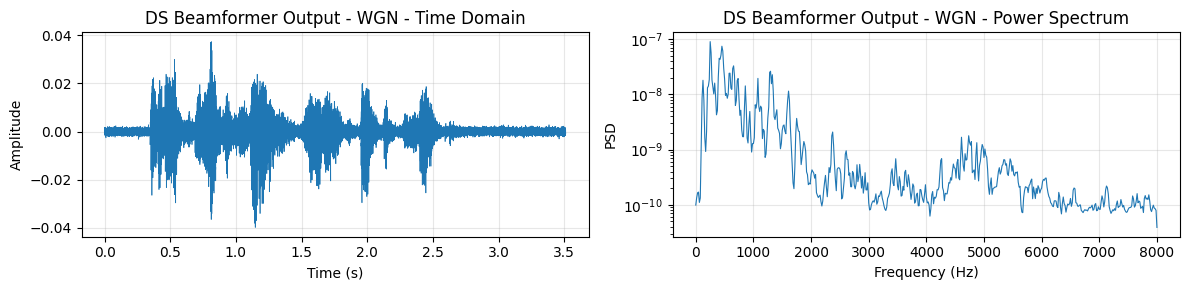

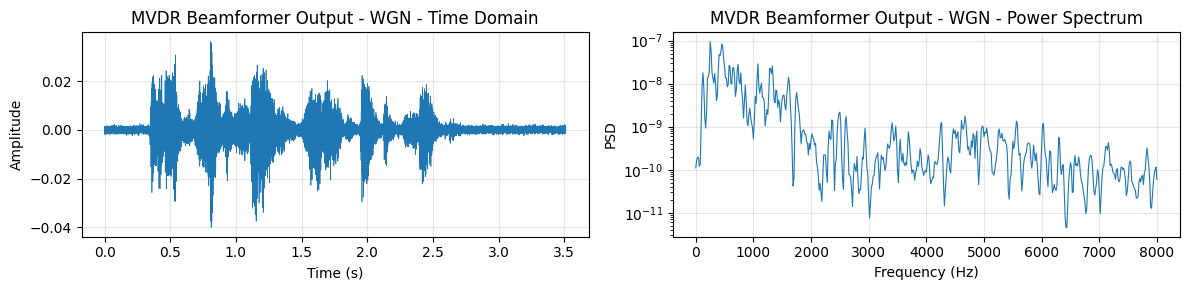

In [97]:
# Settings for visualization
t60_plot = 300
snr_plot = 10

# Get beamformer outputs for WGN noise
ds_wgn = beamformer_outputs['wgn'][t60_plot][snr_plot]['ds']
mvdr_wgn = beamformer_outputs['wgn'][t60_plot][snr_plot]['mvdr']

# Get beamformer outputs for interfering speaker
ds_int = beamformer_outputs['interferer'][t60_plot][snr_plot]['ds']
mvdr_int = beamformer_outputs['interferer'][t60_plot][snr_plot]['mvdr']

# Plot for WGN noise
print("=== White Gaussian Noise (T60=300ms, SNR=10dB) ===")
plot_time_and_spectrum(ds_wgn, fs, 'DS Beamformer Output - WGN')
plot_time_and_spectrum(mvdr_wgn, fs, 'MVDR Beamformer Output - WGN')

=== Interfering Speaker (T60=300ms, SNR=10dB) ===


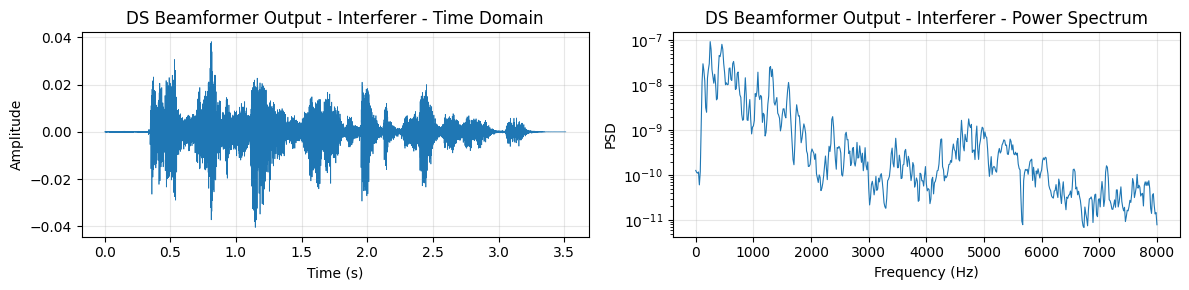

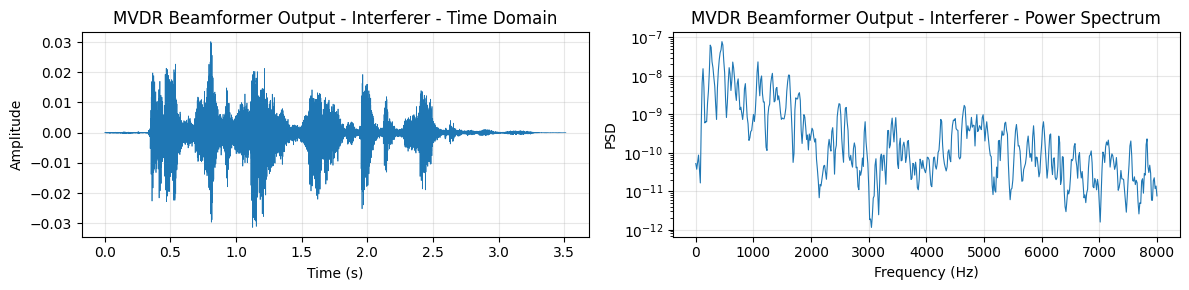

In [98]:
# Plot for interfering speaker noise
print("=== Interfering Speaker (T60=300ms, SNR=10dB) ===")
plot_time_and_spectrum(ds_int, fs, 'DS Beamformer Output - Interferer')
plot_time_and_spectrum(mvdr_int, fs, 'MVDR Beamformer Output - Interferer')

In [99]:
# Save beamformer outputs as WAV files
os.makedirs(out_dir, exist_ok=True)

# Save WGN outputs
sf.write(f'{out_dir}/ds_output_wgn_300ms_10dB.wav', normalize(ds_wgn), fs)
sf.write(f'{out_dir}/mvdr_output_wgn_300ms_10dB.wav', normalize(mvdr_wgn), fs)

# Save interferer outputs
sf.write(f'{out_dir}/ds_output_interferer_300ms_10dB.wav', normalize(ds_int), fs)
sf.write(f'{out_dir}/mvdr_output_interferer_300ms_10dB.wav', normalize(mvdr_int), fs)

print(f"Saved beamformer outputs to {out_dir}/")
print("  - ds_output_wgn_300ms_10dB.wav")
print("  - mvdr_output_wgn_300ms_10dB.wav")
print("  - ds_output_interferer_300ms_10dB.wav")
print("  - mvdr_output_interferer_300ms_10dB.wav")

Saved beamformer outputs to ./outputs/
  - ds_output_wgn_300ms_10dB.wav
  - mvdr_output_wgn_300ms_10dB.wav
  - ds_output_interferer_300ms_10dB.wav
  - mvdr_output_interferer_300ms_10dB.wav


## Q2(e): Quality Metrics Evaluation

Calculate PESQ, ESTOI, and SI-SDR averaged over 20 speech signals.

**Reference signal:** Clean reverberant signal at the first microphone (not the dry source).

In [ ]:
import torch
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality as PESQ
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility as STOI
from torchmetrics.audio.sdr import ScaleInvariantSignalDistortionRatio as SISDR
import glob

# Initialize metrics
pesq_metric = PESQ(fs, 'wb')  # wideband PESQ
estoi_metric = STOI(fs, extended=True)  # extended STOI
sisdr_metric = SISDR()

# Get list of speech files (20 files)
speech_files = sorted(glob.glob('./speech_data/*.flac'))[:20]
print(f"Found {len(speech_files)} speech files for evaluation")

In [ ]:
def match_length(x, target_len):
    """Truncate or zero-pad signal to target length."""
    if len(x) >= target_len:
        return x[:target_len]
    out = np.zeros(target_len)
    out[:len(x)] = x
    return out

def compute_metrics(estimate, reference):
    """Compute PESQ, ESTOI, SI-SDR for a pair of signals."""
    # Ensure same length
    min_len = min(len(estimate), len(reference))
    est = torch.tensor(estimate[:min_len], dtype=torch.float32).unsqueeze(0)
    ref = torch.tensor(reference[:min_len], dtype=torch.float32).unsqueeze(0)
    
    sisdr = sisdr_metric(est, ref).item()
    estoi = estoi_metric(est, ref).item()
    try:
        pesq = pesq_metric(est, ref).item()
    except:
        pesq = float('nan')  # PESQ can fail on some inputs
    
    return sisdr, estoi, pesq

In [ ]:
# Store metrics: metrics[noise_type][t60][snr][method] = list of (sisdr, estoi, pesq) tuples
metrics = {
    'wgn': {t60: {snr: {'ds': [], 'mvdr': []} for snr in snr_levels} for t60 in t60_ms_list},
    'interferer': {t60: {snr: {'ds': [], 'mvdr': []} for snr in snr_levels} for t60 in t60_ms_list}
}

# Process all files
for file_idx, fpath in enumerate(speech_files):
    print(f"Processing file {file_idx+1}/{len(speech_files)}: {os.path.basename(fpath)}")
    
    # Load speech
    speech_sig, _ = librosa.load(fpath, sr=fs)
    
    for t60_ms in t60_ms_list:
        h = rir_dict[t60_ms]
        h_int = rir_interferer[t60_ms]
        
        # Generate clean reverberant signal (reference)
        clean_multi = np.zeros((n_mics, len(speech_sig) + h.shape[0] - 1))
        for m in range(n_mics):
            clean_multi[m] = sig.fftconvolve(speech_sig, h[:, m])
        
        # Reference is first mic of clean reverberant signal
        reference = clean_multi[0]
        
        for snr_db in snr_levels:
            # === WGN noise ===
            noise_wgn = np.random.randn(*clean_multi.shape)
            noise_wgn_scaled = scale_noise_to_snr(clean_multi, noise_wgn, snr_db, ref_mic)
            noisy_wgn_sig = clean_multi + noise_wgn_scaled
            
            # === Interfering speaker ===
            int_len = len(speech_sig)
            if len(interferer_speech) < int_len:
                int_sig = np.tile(interferer_speech, int(np.ceil(int_len / len(interferer_speech))))[:int_len]
            else:
                start = np.random.randint(0, len(interferer_speech) - int_len + 1)
                int_sig = interferer_speech[start:start + int_len]
            
            # Convolve interferer
            int_conv = np.zeros((n_mics, int_len + h_int.shape[0] - 1))
            for m in range(n_mics):
                int_conv[m] = sig.fftconvolve(int_sig, h_int[:, m])
            
            # Align lengths
            max_len = max(clean_multi.shape[1], int_conv.shape[1])
            clean_pad = pad_to_length(clean_multi, max_len)
            int_pad = pad_to_length(int_conv, max_len)
            int_scaled = scale_noise_to_snr(clean_pad, int_pad, snr_db, ref_mic)
            noisy_int_sig = clean_pad + int_scaled
            
            # Apply beamformers - WGN
            ds_out_wgn = delay_and_sum(noisy_wgn_sig, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)
            mvdr_out_wgn = mvdr_beamformer(noisy_wgn_sig, noise_wgn_scaled, fs, n_fft, hop_length, ref_mic)
            
            # Apply beamformers - Interferer
            ds_out_int = delay_and_sum(noisy_int_sig, fs, mic_positions, source_pos, n_fft, hop_length, ref_mic)
            mvdr_out_int = mvdr_beamformer(noisy_int_sig, int_scaled, fs, n_fft, hop_length, ref_mic)
            
            # Compute metrics (reference = clean reverberant at mic 0)
            metrics['wgn'][t60_ms][snr_db]['ds'].append(compute_metrics(ds_out_wgn, reference))
            metrics['wgn'][t60_ms][snr_db]['mvdr'].append(compute_metrics(mvdr_out_wgn, reference))
            metrics['interferer'][t60_ms][snr_db]['ds'].append(compute_metrics(ds_out_int, reference))
            metrics['interferer'][t60_ms][snr_db]['mvdr'].append(compute_metrics(mvdr_out_int, reference))

print("\nMetrics computation complete!")

In [ ]:
# Compute average metrics and create results table
import pandas as pd

results = []

for noise_type in ['wgn', 'interferer']:
    for t60_ms in t60_ms_list:
        for snr_db in snr_levels:
            for method in ['ds', 'mvdr']:
                vals = np.array(metrics[noise_type][t60_ms][snr_db][method])
                mean_sisdr = np.nanmean(vals[:, 0])
                mean_estoi = np.nanmean(vals[:, 1])
                mean_pesq = np.nanmean(vals[:, 2])
                
                results.append({
                    'Noise': noise_type.upper(),
                    'T60 (ms)': t60_ms,
                    'SNR (dB)': snr_db,
                    'Method': method.upper(),
                    'SI-SDR': f'{mean_sisdr:.2f}',
                    'ESTOI': f'{mean_estoi:.3f}',
                    'PESQ': f'{mean_pesq:.2f}'
                })

df_results = pd.DataFrame(results)
print("=== Quality Metrics (averaged over 20 files) ===\n")
print(df_results.to_string(index=False))

In [ ]:
# Plot metrics vs SNR for each noise type and T60
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
metric_names = ['SI-SDR (dB)', 'ESTOI', 'PESQ']
metric_idx = [0, 1, 2]

for row, noise_type in enumerate(['wgn', 'interferer']):
    for col, (m_name, m_idx) in enumerate(zip(metric_names, metric_idx)):
        ax = axes[row, col]
        
        for t60_ms in t60_ms_list:
            for method in ['ds', 'mvdr']:
                vals = []
                for snr_db in snr_levels:
                    arr = np.array(metrics[noise_type][t60_ms][snr_db][method])
                    vals.append(np.nanmean(arr[:, m_idx]))
                
                linestyle = '-' if t60_ms == 150 else '--'
                marker = 'o' if method == 'ds' else 's'
                label = f'{method.upper()}, T60={t60_ms}ms'
                ax.plot(snr_levels, vals, marker=marker, linestyle=linestyle, label=label)
        
        ax.set_xlabel('SNR (dB)')
        ax.set_ylabel(m_name)
        ax.set_title(f'{noise_type.upper()} - {m_name}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{out_dir}/metrics_comparison.png', dpi=150)
plt.show()

In [ ]:
# Save results to CSV
df_results.to_csv(f'{out_dir}/metrics_results.csv', index=False)
print(f"Results saved to {out_dir}/metrics_results.csv")